# FashionMNIST Autoencoder & VAE (Fixed, Working)
    

Fitur utama:
- **Convolutional Autoencoder (AE)** dan **Variational Autoencoder (VAE)** dengan **≥3 lapis** encoder & decoder.
- Dataset **FashionMNIST** (auto-download).
- Visualisasi **rekonstruksi**, **ruang laten** (2D / t-SNE), dan **interpolasi laten**.
- Kode **stabil** (perbaikan umum: dimensi feature map, head `mu`/`logvar`, training loop VAE/AE, device handling).

> Jalankan sel-sel dari atas ke bawah. Ubah `CFG.model_type` ke `"AE"` atau `"VAE"`. Untuk eksplor kreatif, bisa atur `latent_dim`, `epochs`, dll.


In [1]:
# 1) Imports & Config (CPU/GPU aman)
import os, math, random, time
from dataclasses import dataclass
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, utils as vutils
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    # MPS kadang tidak stabil untuk beberapa operator ConvTranspose; fallback ke CPU bila error
    try:
        if torch.backends.mps.is_available():
            return torch.device('mps')
    except Exception:
        pass
    return torch.device('cpu')

@dataclass
class CFG:
    model_type: str = 'AE'   # 'AE' atau 'VAE'
    batch_size: int = 128
    lr: float = 1e-3
    epochs: int = 8
    latent_dim: int = 2       # 2 memudahkan visualisasi
    recon_every: int = 2      # tampilkan rekonstruksi tiap N epoch
    num_workers: int = 2

device = get_device()
device

device(type='cuda')

In [2]:
# 2) Dataset: FashionMNIST (28x28, grayscale)
transform = transforms.Compose([
    transforms.ToTensor(),                    # [0,1]
    transforms.Normalize((0.5,), (0.5,))      # [-1,1]
])

train_set = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_set  = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)
test_loader  = DataLoader(test_set,  batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

in_channels = 1
img_size = 28

xb, yb = next(iter(train_loader))
print('Sample batch:', xb.shape, yb.shape)

100%|██████████| 26.4M/26.4M [00:00<00:00, 113MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.76MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 63.8MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.1MB/s]


Sample batch: torch.Size([128, 1, 28, 28]) torch.Size([128])


In [3]:
# 3) Arsitektur Model (≥3 layer encoder & decoder)
# Encoder backbone: Conv -> Conv -> Conv (downsample 28->14->7->4), lalu FC
class ConvEncoder(nn.Module):
    def __init__(self, in_channels=1, latent_dim=2, hidden_fc=256, img_size=28):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, stride=2, padding=1),  # 28->14
            nn.BatchNorm2d(32), nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),           # 14->7
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),          # 7->4
            nn.BatchNorm2d(128), nn.ReLU(True),
        )
        # feature map size setelah 3x downsample: 4x4
        self.ds = 4
        flat = 128 * self.ds * self.ds
        self.fc = nn.Linear(flat, hidden_fc)
        # AE head
        self.to_z = nn.Linear(hidden_fc, latent_dim)
        # VAE heads
        self.to_mu = nn.Linear(hidden_fc, latent_dim)
        self.to_logvar = nn.Linear(hidden_fc, latent_dim)

    def forward_backbone(self, x):
        h = self.conv(x)
        h = h.view(h.size(0), -1)
        h = self.fc(h)
        return h

    def forward_ae(self, x):
        h = self.forward_backbone(x)
        z = self.to_z(h)
        return z

    def forward_vae(self, x):
        h = self.forward_backbone(x)
        mu = self.to_mu(h)
        logvar = self.to_logvar(h)
        return mu, logvar

class ConvDecoder(nn.Module):
    def __init__(self, out_channels=1, latent_dim=2, hidden_fc=256, ds=4):
        super().__init__()
        self.ds = ds
        self.fc = nn.Linear(latent_dim, 128*ds*ds)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # 4->8
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),   # 8->16
            nn.BatchNorm2d(32), nn.ReLU(True),
            nn.ConvTranspose2d(32, out_channels, 3, stride=2, padding=1, output_padding=1), # 16->32
            nn.Tanh()
        )

    def forward(self, z):
        h = self.fc(z)
        h = h.view(h.size(0), 128, self.ds, self.ds)
        xrec = self.deconv(h)
        # output 32x32, kita center-crop ke 28x28 agar match input
        xrec = torch.nn.functional.interpolate(xrec, size=(28,28), mode='bilinear', align_corners=False)
        return xrec

class AE(nn.Module):
    def __init__(self, in_channels=1, latent_dim=2):
        super().__init__()
        self.enc = ConvEncoder(in_channels=in_channels, latent_dim=latent_dim)
        self.dec = ConvDecoder(out_channels=in_channels, latent_dim=latent_dim, ds=self.enc.ds)
    def forward(self, x):
        z = self.enc.forward_ae(x)
        xrec = self.dec(z)
        return xrec, z

class VAE(nn.Module):
    def __init__(self, in_channels=1, latent_dim=2):
        super().__init__()
        self.enc = ConvEncoder(in_channels=in_channels, latent_dim=latent_dim)
        self.dec = ConvDecoder(out_channels=in_channels, latent_dim=latent_dim, ds=self.enc.ds)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.enc.forward_vae(x)
        z = self.reparameterize(mu, logvar)
        xrec = self.dec(z)
        return xrec, z, mu, logvar

def build_model(model_type='AE', latent_dim=2, in_channels=1):
    if model_type == 'AE':
        return AE(in_channels=in_channels, latent_dim=latent_dim)
    elif model_type == 'VAE':
        return VAE(in_channels=in_channels, latent_dim=latent_dim)
    else:
        raise ValueError("model_type harus 'AE' atau 'VAE'")


In [4]:
# 4) Losses & Utils
def recon_loss(xrec, x):
    return F.mse_loss(xrec, x, reduction='mean')

def kl_divergence(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

def show_grid(tensor, title, nrow=8):
    grid = vutils.make_grid(tensor, nrow=nrow, normalize=True, value_range=(-1,1))
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(grid.cpu().numpy(), (1,2,0)))
    plt.show()

In [5]:
# 5) Build model & optimizer
model = build_model(CFG.model_type, CFG.latent_dim, in_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)
print(model.__class__.__name__, 'on', device)

AE on cuda


In [6]:
# 6) Training & Eval Loops
def train_epoch(model, loader):
    model.train()
    total = 0.0; n = 0
    for x, _ in loader:
        x = x.to(device)
        optimizer.zero_grad()
        if isinstance(model, AE):
            xrec, z = model(x)
            loss = recon_loss(xrec, x)
        else:
            xrec, z, mu, logvar = model(x)
            loss = recon_loss(xrec, x) + kl_divergence(mu, logvar)
        loss.backward()
        optimizer.step()
        total += loss.item() * x.size(0)
        n += x.size(0)
    return total / n

@torch.no_grad()
def eval_epoch(model, loader):
    model.eval()
    total = 0.0; n = 0
    for x, _ in loader:
        x = x.to(device)
        if isinstance(model, AE):
            xrec, z = model(x)
            loss = recon_loss(xrec, x)
        else:
            xrec, z, mu, logvar = model(x)
            loss = recon_loss(xrec, x) + kl_divergence(mu, logvar)
        total += loss.item() * x.size(0)
        n += x.size(0)
    return total / n

Epoch 01/8 | train=0.1578 | val=0.1322
Epoch 02/8 | train=0.1299 | val=0.1256


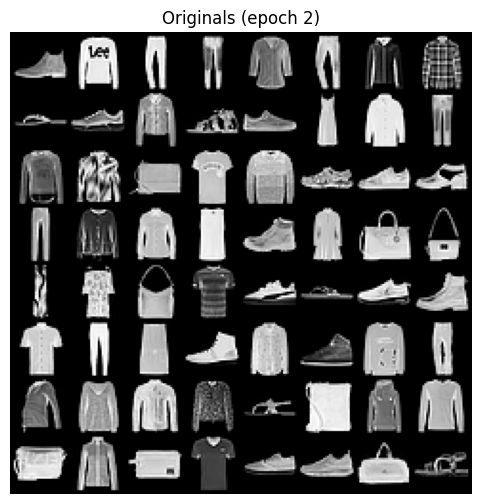

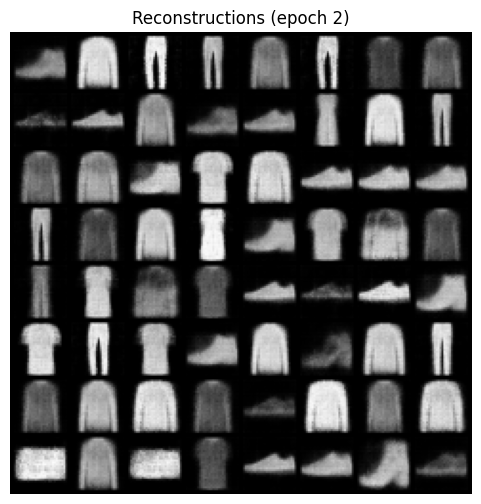

Epoch 03/8 | train=0.1256 | val=0.1227
Epoch 04/8 | train=0.1226 | val=0.1228


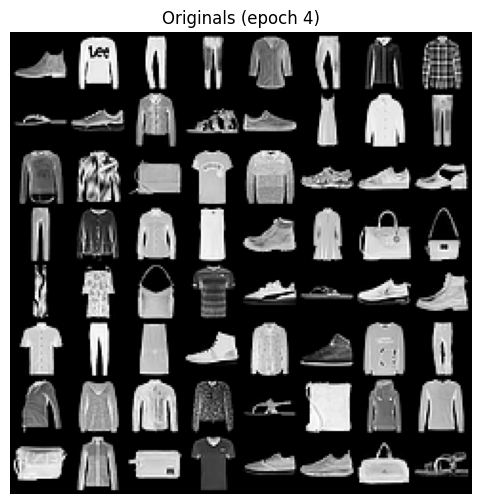

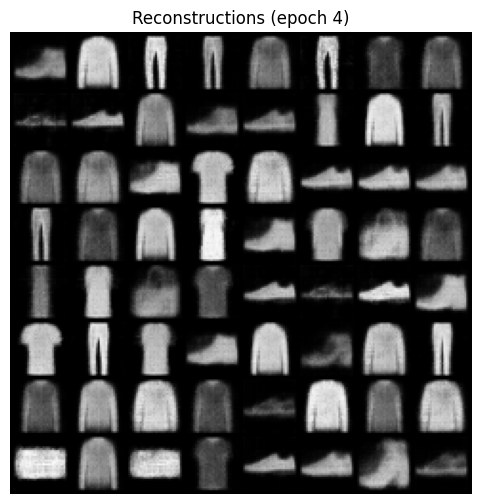

Epoch 05/8 | train=0.1205 | val=0.1237
Epoch 06/8 | train=0.1192 | val=0.1180


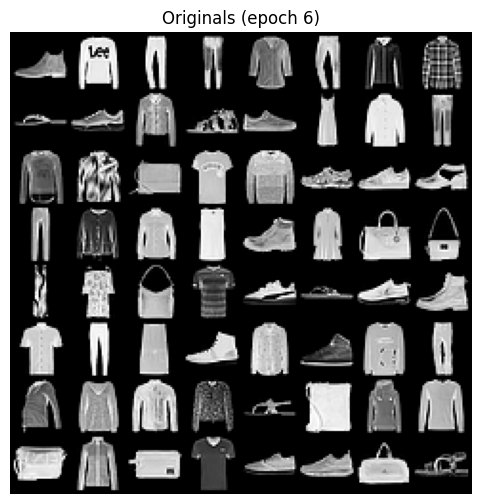

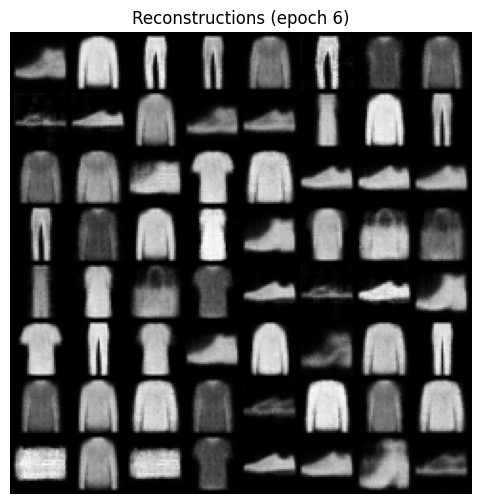

Epoch 07/8 | train=0.1178 | val=0.1169
Epoch 08/8 | train=0.1169 | val=0.1204


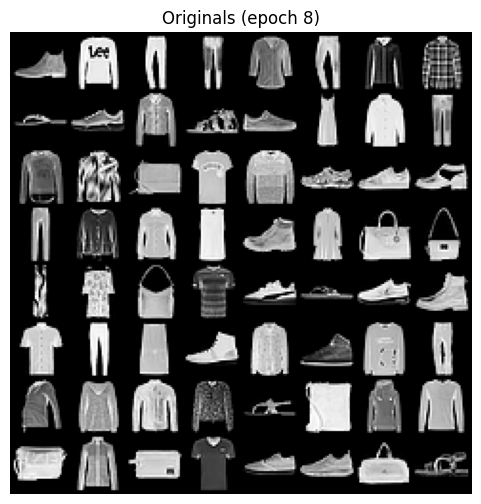

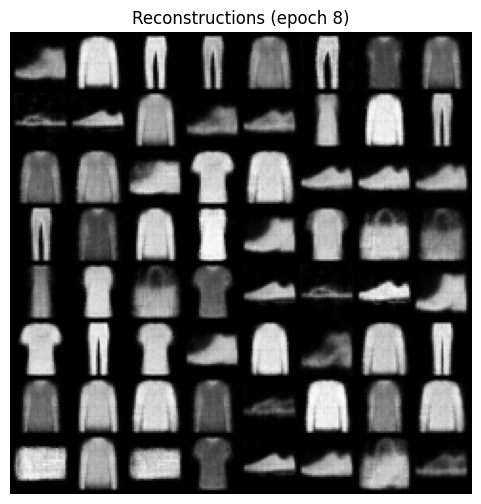

Done in 70.5 s


In [7]:
# 7) Run Training (ringan; ubah epochs jika perlu)
start = time.time()
best = float('inf')
for epoch in range(1, CFG.epochs+1):
    tr = train_epoch(model, train_loader)
    va = eval_epoch(model, test_loader)
    print(f"Epoch {epoch:02d}/{CFG.epochs} | train={tr:.4f} | val={va:.4f}")
    if (epoch % CFG.recon_every) == 0:
        xb, _ = next(iter(test_loader))
        xb = xb.to(device)
        if isinstance(model, AE):
            xrec, _ = model(xb)
        else:
            xrec, *_ = model(xb)
        show_grid(xb[:64], f"Originals (epoch {epoch})", nrow=8)
        show_grid(xrec[:64], f"Reconstructions (epoch {epoch})", nrow=8)
print('Done in', round(time.time()-start,1), 's')

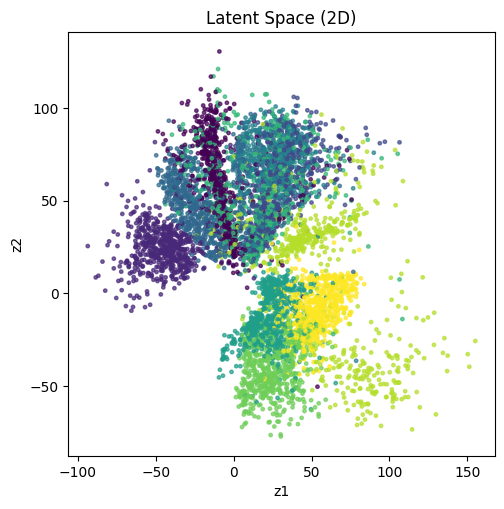

In [8]:
# 8) Visualisasi ruang laten (2D langsung atau t-SNE)
@torch.no_grad()
def collect_latents(model, loader, max_batches=50):
    model.eval()
    Z, Y = [], []
    b = 0
    for x, y in loader:
        x = x.to(device)
        if isinstance(model, AE):
            _, z = model(x)
        else:
            _, z, mu, logvar = model(x)
            z = mu  # gunakan mean untuk stabil
        Z.append(z.cpu().numpy())
        Y.append(y.numpy())
        b += 1
        if b >= max_batches: break
    return np.concatenate(Z, 0), np.concatenate(Y, 0)

Z, Y = collect_latents(model, test_loader)

if Z.shape[1] == 2:
    plt.figure(figsize=(5.5,5.5))
    plt.scatter(Z[:,0], Z[:,1], s=6, alpha=0.7, c=Y)
    plt.title('Latent Space (2D)')
    plt.xlabel('z1'); plt.ylabel('z2')
    plt.show()
else:
    tsne = TSNE(n_components=2, init='random', random_state=SEED, perplexity=30, learning_rate='auto')
    Z2 = tsne.fit_transform(Z)
    plt.figure(figsize=(5.5,5.5))
    plt.scatter(Z2[:,0], Z2[:,1], s=6, alpha=0.7, c=Y)
    plt.title('Latent Space (t-SNE)')
    plt.xlabel('tsne-1'); plt.ylabel('tsne-2')
    plt.show()

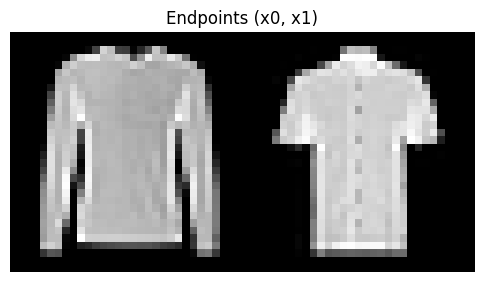

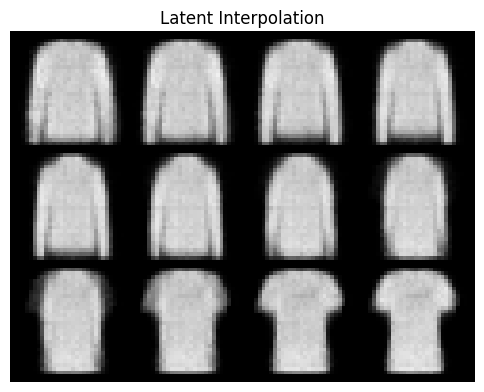

In [9]:
# 9) Interpolasi laten
@torch.no_grad()
def latent_interpolation(model, loader, steps=12):
    model.eval()
    x, _ = next(iter(loader))
    idx = np.random.choice(len(x), 2, replace=False)
    x0 = x[idx[0]:idx[0]+1].to(device)
    x1 = x[idx[1]:idx[1]+1].to(device)
    if isinstance(model, AE):
        _, z0 = model(x0); _, z1 = model(x1)
    else:
        _, _, mu0, lv0 = model(x0); _, _, mu1, lv1 = model(x1)
        z0, z1 = mu0, mu1
    alphas = torch.linspace(0,1,steps, device=device).view(-1,1)
    Z = (1-alphas)*z0 + alphas*z1
    x_interp = model.dec(Z)
    # tampilkan
    from torchvision.utils import make_grid
    show_grid(torch.cat([x0, x1], dim=0), "Endpoints (x0, x1)", nrow=2)
    show_grid(x_interp, "Latent Interpolation", nrow=steps//3 if steps>=6 else steps)

latent_interpolation(model, test_loader, steps=12)

In [10]:
# 10) Simpan artefak
import numpy as np
from pathlib import Path
out = Path('outputs'); out.mkdir(exist_ok=True, parents=True)
torch.save(model.state_dict(), out / f"{type(model).__name__}_lat{CFG.latent_dim}.pt")
np.save(out / "latents.npy", Z)
np.save(out / "labels.npy", Y)
print("Saved model & latents to", out.resolve())

Saved model & latents to /kaggle/working/outputs


## 11) Catatan Debug yang Diperbaiki
- **Head `mu`/`logvar`** dipisah dari backbone encoder agar VAE stabil.
- **Output decoder** yang jadi 32×32 di-**resize** kembali ke 28×28 supaya cocok dengan input FashionMNIST.
- **Loss VAE** = `MSE + KL` (tanpa `β` — bisa kamu tambah mudah).
- **Device selection**: aman untuk CUDA/MPS/CPU.
- **Training loop**: memisahkan AE dan VAE secara eksplisit.
